In [37]:
# Imports
import os
import sys

import pandas as pd

root_path = os.path.abspath(os.path.join('..', '..', '..'))
if root_path not in sys.path:
    sys.path.append(root_path)

from analysis.src.python.data_analysis.model.column_name import StepColumns
from analysis.src.python.utils.df_utils import read_df, filter_df_by_single_value


In [38]:
# Setup paths to datasets

BASE_PATH = ""

STEPS_DATA = f"{BASE_PATH}/steps.csv"
USERS_DATA = f"{BASE_PATH}/users.csv"
SUBMISSIONS_DATA = f"{BASE_PATH}/solutions_java11_raw_issues.csv"
TEMPLATES_DATA = f"{BASE_PATH}/issues/template_issues.csv"

In [39]:
# Upload all dataframes

steps_df = read_df(STEPS_DATA)
users_df = read_df(USERS_DATA)
submissions_df = read_df(SUBMISSIONS_DATA)
templates_df = read_df(TEMPLATES_DATA)

In [40]:
# General statistics about the dataset

def unique_values_by_column(df: pd.DataFrame, column: str) -> pd.DataFrame:
    return df[column].dropna().unique()


steps_count = len(unique_values_by_column(steps_df, StepColumns.ID.value))
users_count = len(unique_values_by_column(users_df, StepColumns.ID.value))

print(f"Steps count: {steps_count}")
print(f"Users count: {users_count}")

steps_with_templates_df = filter_df_by_single_value(steps_df, StepColumns.HAS_TEMPLATE.value, True)
steps_with_templates = len(unique_values_by_column(steps_with_templates_df, StepColumns.ID.value))

print(f"Steps with template count: {steps_with_templates}")

submissions_count_initial = len(unique_values_by_column(submissions_df, StepColumns.ID.value))
print(f"Submissions count initial: {submissions_count_initial}")

Steps count: 415
Users count: 37626
Steps with template count: 415
Submissions count initial: 1065579


In [41]:
from data_analysis.model.column_name import SubmissionColumns, TemplateColumns

# Templates stats

steps_with_templates_issues = len(unique_values_by_column(templates_df, SubmissionColumns.STEP_ID.value))
print(f"Steps count that have code quality issues in templates: {steps_with_templates_issues}")

all_steps = set(unique_values_by_column(steps_df, SubmissionColumns.ID.value))
steps_with_template_issues = set(unique_values_by_column(templates_df, SubmissionColumns.STEP_ID.value))
steps_without_template_issues = all_steps - steps_with_template_issues
print(f"Steps count that DON'T have code quality issues in templates: {len(steps_without_template_issues)}")

Steps count that have code quality issues in templates: 61
Steps count that DON'T have code quality issues in templates: 354


<AxesSubplot:>

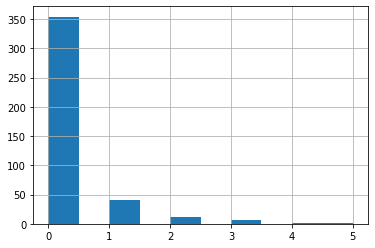

In [47]:
# Count errors types by steps

counter_column = 'counter'
steps_errors_count_df = templates_df.groupby(SubmissionColumns.STEP_ID.value)[
    SubmissionColumns.RAW_ISSUE_CLASS.value].nunique().reset_index(name=counter_column)
all_steps = set(unique_values_by_column(steps_df, SubmissionColumns.ID.value))
steps_with_template_issues = set(unique_values_by_column(templates_df, SubmissionColumns.STEP_ID.value))
steps_without_template_issues = all_steps - steps_with_template_issues
for step in steps_without_template_issues:
    steps_errors_count_df = steps_errors_count_df.append({SubmissionColumns.STEP_ID.value: step, counter_column: 0},
                                                         ignore_index=True)

steps_errors_count_df[counter_column].hist()

In [54]:
# Top code quality issues in templates

def issue_count(row: pd.DataFrame) -> int:
    if pd.isnull(row[TemplateColumns.POS_IN_TEMPLATE.value]):
        return 1
    return len(row[TemplateColumns.POS_IN_TEMPLATE.value].split(", "))


templates_df[counter_column] = templates_df.apply(issue_count, axis=1)
issues_counter_df = templates_df.groupby(SubmissionColumns.RAW_ISSUE_CLASS.value)[counter_column].sum().reset_index(
    name=counter_column).sort_values(counter_column, ascending=False)

print(issues_counter_df.head)

<bound method NDFrame.head of                           origin_class  counter
11                    MagicNumberCheck       68
4               CallSuperInConstructor       27
7              EmptyLineSeparatorCheck       26
8                     IndentationCheck       16
17                  UnusedImportsCheck        8
5                    ConstantNameCheck        5
1   AbstractClassWithoutAbstractMethod        3
10          LiteralsFirstInComparisons        2
12                     MemberNameCheck        2
21               WhitespaceAroundCheck        2
6    ConstructorCallsOverridableMethod        2
9                      LineLengthCheck        1
3     AvoidFieldNameMatchingMethodName        1
13             MissingSerialVersionUID        1
14                  ParameterNameCheck        1
15                  PreserveStackTrace        1
16                       SingularField        1
2                  AssignmentInOperand        1
18                  UnusedPrivateField        1
19        

In [55]:
from hyperstyle.src.python.review.inspectors.detekt.issue_types import DETEKT_CLASS_NAME_TO_ISSUE_TYPE
from hyperstyle.src.python.review.inspectors.checkstyle.issue_types import CHECK_CLASS_NAME_TO_ISSUE_TYPE
from hyperstyle.src.python.review.inspectors.issue import IssueType

# Top code quality issues in templates by categories

all_categories = [IssueType.CODE_STYLE.value, IssueType.BEST_PRACTICES.value, IssueType.ERROR_PRONE.value,
                  IssueType.COMPLEXITY.value, IssueType.INFO.value]


def get_issue_category(issue: str) -> IssueType:
    issue_type = CHECK_CLASS_NAME_TO_ISSUE_TYPE.get(issue)
    if issue_type is not None:
        return issue_type
    issue_type = DETEKT_CLASS_NAME_TO_ISSUE_TYPE.get(issue)
    if issue_type is not None:
        return issue_type
    # According to the Hyperstyle tool
    return IssueType.BEST_PRACTICES


category_column = 'category'
templates_df[category_column] = templates_df.apply(
    lambda row: get_issue_category(row[SubmissionColumns.RAW_ISSUE_CLASS.value]).to_main_type().value, axis=1)

issues_counter_by_category_df = templates_df.groupby(category_column)[counter_column].sum().reset_index(
    name=counter_column).sort_values(counter_column, ascending=False)
missed_categories = set(all_categories) - set(unique_values_by_column(issues_counter_by_category_df, category_column))

for category in missed_categories:
    issues_counter_by_category_df = issues_counter_by_category_df.append({category_column: category, counter_column: 0},
                                                                         ignore_index=True)

print(issues_counter_by_category_df)

         category  counter
0            INFO       68
1      CODE_STYLE       54
2  BEST_PRACTICES       50
3     ERROR_PRONE        0
4      COMPLEXITY        0
